In [1]:
#fundamental tools for the game environment model
import numpy as np
from multiprocess import Process, Queue, Semaphore, Lock
import time

# for visualations
import matplotlib.pyplot as plt

In [2]:
from randomchooser import Chooser
from exploresims import simulate_explore, sim_1
import explore

pygame 2.5.1 (SDL 2.28.2, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
game = explore.ExploreGame()

In [4]:
pattern = game.build_map()

In [5]:
pattern.trace()

16

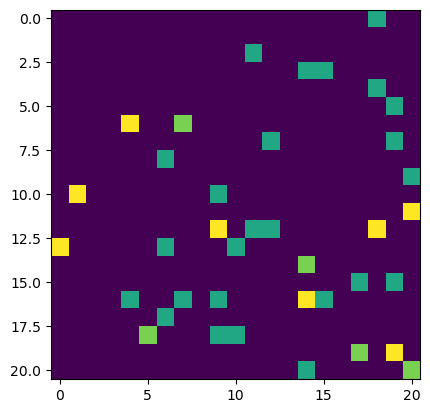

In [6]:
plt.imshow(pattern)

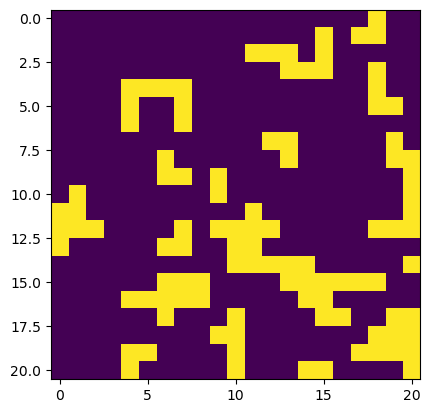

In [7]:
plt.imshow(game.board)

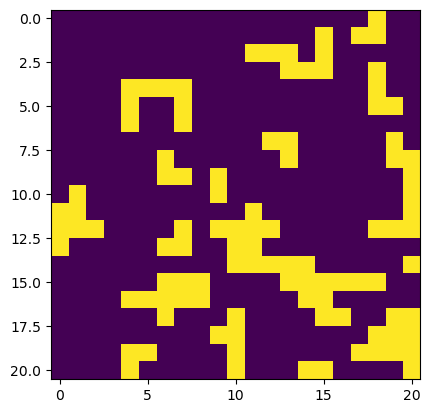

In [8]:
plt.imshow(game.board)

In [9]:
game.clean_diagonal_walls()

True

In [3]:
max_processes = 8
sem = Semaphore(max_processes)
out_lock = Lock()
output_queue = Queue()
pos_queue = Queue()

In [4]:
# make positions available
num_cols = 3
for i in range(max_processes):
    x = 30 + (i%num_cols) * (610 + 30) 
    y = 40 + (i//num_cols)*(300 + 40)
    pos_queue.put((x,y))

In [3]:
choosers = []
#choosers.append(Chooser(5))
for i in range(7, 13):
    choosers.append(Chooser(5, [10,10,10,10,10], i))
#for i in range(5,16):
    #choosers.append(Chooser(5, [0,10,10,10,0], i))

In [6]:
if __name__ == '__main__':
    sims = []
    for ch in choosers:
        curr_args = [sem, out_lock, output_queue, 1000,100, 80, ch, 21,
                     300, 60, 1.28, True, pos_queue]
        p = Process(target=simulate_explore, args=curr_args)
        sims.append(p)
        
    for sim in sims:
        sim.start()

In [5]:
out = sim_1(choosers)


In [6]:
results = out

In [7]:
results = []
while not output_queue.empty():
    results.append(output_queue.get())

In [7]:
len(results)

6

In [8]:
for k in range(len(results)):
    max_winrate = 0
    pos = 0
    for i in range(k, len(results)):
        if results[i][2][0] > max_winrate:
            max_winrate = results[i][2][0]
            pos = i
    temp = results[k]
    results[k] = results[pos]
    results[pos] = temp

In [9]:
for i in range(len(results)):
    print(results[i][2][0])

9.08
9.02
8.93
8.74
8.72
8.71


In [11]:
for i in range(6):
    print(results[i][0], results[i][1])

[10, 10, 10, 10, 10] 7
[10, 10, 10, 10, 10] 10
[10, 10, 10, 10, 10] 9
[10, 10, 10, 10, 10] 12
[10, 10, 10, 10, 10] 8
[10, 10, 10, 10, 10] 11


In [12]:
for k in range(len(results)):
    min_trace_stdev = results[k][3][0]
    pos = k
    for i in range(k,len(results)):
        if results[i][3][0] < min_trace_stdev:
            min_trace_stdev = results[i][3][0]
            pos = i
    temp = results[k]
    results[k] = results[pos]
    results[pos] = temp

In [13]:
for i in range(len(results)):
    print(results[i][3][0])

15.917994362003402
16.139560063942092
16.226427348288027
16.554744225737007
16.75887923617351
17.070463787822163


In [14]:
for i in range(6):
    print(results[i][0], results[i][1])

[10, 10, 10, 10, 10] 7
[10, 10, 10, 10, 10] 8
[10, 10, 10, 10, 10] 9
[10, 10, 10, 10, 10] 11
[10, 10, 10, 10, 10] 10
[10, 10, 10, 10, 10] 12


In [9]:
weights = []
durations = []
win_data = []
stdev_data = []
trace_averages = []
for result in results:
    weights.append(result[0])
    durations.append(result[1])
    win_data.append(result[2])
    stdev_data.append(result[3])
    trace_averages.append(result[4])

In [10]:
win_averages = []
win_stds = []
win_errors = []
for win in win_data:
    win_averages.append(win[0])
    win_stds.append(win[1])
    win_errors.append(win[2])

In [11]:
stdev_averages = []
stdev_stds = []
stdev_errors = []
for stdev in stdev_data:
    stdev_averages.append(stdev[0])
    stdev_stds.append(stdev[1])
    stdev_errors.append(stdev[2])

In [12]:
for (mean, error) in zip(stdev_averages, stdev_errors):
    print(mean, error)

21.915006421778063 0.10708246384246096
15.2103472534303 0.08477570267273185
16.418986514123485 0.08330403448770658
17.957885942316455 0.082570717415026
19.480932797157642 0.08758232776463426
21.781383165100706 0.09574792182765507
15.629925028396283 0.08976795817382
13.687060319755307 0.06589713849537174
14.736647638912821 0.08364109341070006
14.072948662005137 0.08261498998746902
13.682836146118154 0.09185016762984498
14.127084552989043 0.08014547039543578


In [3]:
ch1 = Chooser(5)
ch2 = Chooser(5, [1,10,10,10,1])

In [5]:
lol1 = Process(target=simulate_explore, args=[sem, out_lock, output_queue, 100,100,40, ch1, 15, 1.08])
lol2 = Process(target=simulate_explore, args=[sem, out_lock, output_queue, 100,100,40, ch2, 15, 1.08])

In [6]:
lol1.start()
lol2.start()

In [8]:
lol1.join()
lol2.join()